# Part-of-Speech Tagging using Recurrent Neural Networks (RNN and LSTM)
Author: Pierre Nugues

A part-of-speech tagger using recurrent networks and GloVe embeddings and trained on a corpus following the Universal Dependencies format. Here we use the English Web Treebank:
https://github.com/UniversalDependencies/UD_English-EWT/tree/master.

## Python Headers

### The Modules

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Some Parameters

In [3]:
BATCH_SIZE = 32
EPOCHS = 10
MINI_CORPUS = True
LSTM_HIDDEN_DIM = 128
LSTM_LAYERS = 2
DROPOUT = 0.20
EMB_LARGE = True # GloVe 50 or 100
FREEZE_EMBS = True
LARGE_MEM = False

In [4]:
config = {'EPOCHS': EPOCHS, 
'LSTM_HIDDEN_DIM': LSTM_HIDDEN_DIM,
'LSTM_LAYERS': LSTM_LAYERS,
'DROPOUT': DROPOUT,
'EMB_LARGE': EMB_LARGE,
'FREEZE_EMBS': FREEZE_EMBS}

In [5]:
random.seed(1234)
torch.manual_seed(1234)

## Preprocessing

### Loading the Embeddings
We will use GloVe embeddings and load them

In [6]:
if EMB_LARGE:
    embedding_file = '/Users/pierre/Documents/Cours/EDAN20/corpus/glove.6B.100d.txt'
    EMBEDDING_DIM = 100
else:
    embedding_file = '/Users/pierre/Documents/Cours/EDAN20/corpus/glove.6B.50d.txt'
    EMBEDDING_DIM = 50

In [7]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = torch.FloatTensor(list(map(float, values[1:])))
        embeddings[word] = vector
    glove.close()
    return embeddings

In [8]:
embeddings_dict = read_embeddings(embedding_file)

In [9]:
embeddings_dict['table']

tensor([-0.6145,  0.8969,  0.5677,  0.3910, -0.2244,  0.4904,  0.1087,  0.2741,
        -0.2383, -0.5215,  0.7355, -0.3265,  0.5130,  0.3241, -0.4671,  0.6805,
        -0.2550, -0.0405, -0.5442, -1.0548, -0.4669,  0.2356,  0.3123, -0.3454,
         0.1479, -0.5375, -0.4322, -0.4872, -0.5102, -0.9051, -0.1792, -0.0184,
         0.0972, -0.3162,  0.7512,  0.9224, -0.4997,  0.1404, -0.2830, -0.9744,
        -0.0094, -0.6294,  0.1471, -0.9438,  0.0075,  0.1857, -0.9917,  0.0728,
        -0.1847, -0.5290,  0.3900, -0.4568, -0.2193,  1.3723, -0.2964, -2.2342,
        -0.3667,  0.0499,  0.6342,  0.5328, -0.5396,  0.3140, -0.4470, -0.3839,
         0.0667, -0.0217,  0.2056,  0.5946, -0.2489, -0.5279, -0.3761,  0.0771,
         0.7522, -0.2647, -0.0587,  0.6754, -0.1656, -0.4928, -0.2633, -0.2121,
         0.2432,  0.1701, -0.2926, -0.5009, -0.5664, -0.4038, -0.4845, -0.3254,
         0.7529,  0.0050, -0.3212,  0.2890, -0.0424,  0.6386, -0.2033, -0.4678,
        -0.1566,  0.2179,  1.4143,  0.40

### Loading the Corpus

In [10]:
def load_ud_en_ewt():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/ud-treebanks-v2.9/UD_English-EWT/'
    train_file = BASE_DIR + 'en_ewt-ud-train.conllu'
    dev_file = BASE_DIR + 'en_ewt-ud-dev.conllu'
    test_file = BASE_DIR + 'en_ewt-ud-test.conllu'
    column_names = ['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 
                    'FEATS', 'HEAD', 'DEPREL', 'HEAD', 'DEPS', 'MISC']
    column_names = list(map(str.lower, column_names))
    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

def load_conll2009_pos():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/conll2009/en/'
    train_file = BASE_DIR + 'CoNLL2009-ST-English-train-pos.txt'
    dev_file = BASE_DIR + 'CoNLL2009-ST-English-development-pos.txt'
    test_file = BASE_DIR + 'CoNLL2009-ST-test-words-pos.txt'
    # test2_file = 'simple_pos_test.txt'

    column_names = ['id', 'form', 'lemma', 'plemma', 'pos', 'ppos']

    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

# train_sentences, dev_sentences, test_sentences, column_names = \
# load_conll2009_pos()
train_sentences, dev_sentences, test_sentences, column_names =\
load_ud_en_ewt()
train_sentences[:100]

'# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000\n# sent_id = weblog-jua'

### Converting the Corpus in a Dictionary
We follow the fit-transform pattern of sklearn

In [11]:
import regex as re

class Token(dict):
    pass

class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        rows = [row for row in rows if row[0] != '#']
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [12]:
conll_dict = CoNLLDictorizer(column_names, col_sep='\t')

train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

if MINI_CORPUS:
    train_dict = train_dict[:len(train_dict) // 5]
print('First sentence, train:', train_dict[0])

First sentence, train: [{'id': '1', 'form': 'Al', 'lemma': 'Al', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '0:root', 'deprel': 'root', 'deps': 'SpaceAfter=No'}, {'id': '2', 'form': '-', 'lemma': '-', 'upos': 'PUNCT', 'xpos': 'HYPH', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': 'SpaceAfter=No'}, {'id': '3', 'form': 'Zaman', 'lemma': 'Zaman', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '1:flat', 'deprel': 'flat', 'deps': '_'}, {'id': '4', 'form': ':', 'lemma': ':', 'upos': 'PUNCT', 'xpos': ':', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': '_'}, {'id': '5', 'form': 'American', 'lemma': 'American', 'upos': 'ADJ', 'xpos': 'JJ', 'feats': 'Degree=Pos', 'head': '6:amod', 'deprel': 'amod', 'deps': '_'}, {'id': '6', 'form': 'forces', 'lemma': 'force', 'upos': 'NOUN', 'xpos': 'NNS', 'feats': 'Number=Plur', 'head': '7:nsubj', 'deprel': 'nsubj', 'deps': '_'}, {'id': '7', 'form': 'killed', 'lemma': 'kill', 'upos': 'VERB', 'xpos'

### Function to build the two-way sequences
Two vectors: $\mathbf{x}$ and $\mathbf{y}$

In [13]:
def build_sequences(corpus_dict, key_x='form', key_y='upos', tolower=True):
    """
    Creates sequences from a list of dictionaries
    :param corpus_dict:
    :param key_x:
    :param key_y:
    :return:
    """
    X = []
    Y = []
    for sentence in corpus_dict:
        x = []
        y = []
        for word in sentence:
            x += [word[key_x]]
            y += [word[key_y]]
        if tolower:
            x = list(map(str.lower, x))
        X += [x]
        Y += [y]
    return X, Y

In [14]:
X_train_cat, Y_train_cat = build_sequences(train_dict)
X_val_cat, Y_val_cat = build_sequences(dev_dict)
print('First sentence, words', X_train_cat[0])
print('First sentence, POS', Y_train_cat[0])

First sentence, words ['al', '-', 'zaman', ':', 'american', 'forces', 'killed', 'shaikh', 'abdullah', 'al', '-', 'ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'qaim', ',', 'near', 'the', 'syrian', 'border', '.']
First sentence, POS ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']


### Extracting the Unique Words and Parts of Speech

In [15]:
vocabulary_words = sorted(list(
    set([word for sentence 
         in X_train_cat for word in sentence])))
pos = sorted(list(set([pos for sentence 
                       in Y_train_cat for pos in sentence])))
print(pos)
NB_CLASSES = len(pos)

['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', '_']


### We create the dictionary
We add two words for the padding symbol and unknown words

In [16]:
embeddings_words = embeddings_dict.keys()
print('Words in GloVe:',  len(embeddings_dict.keys()))
vocabulary_words = sorted(list(set(vocabulary_words + 
                                   list(embeddings_words))))
cnt_uniq = len(vocabulary_words) + 2
print('# unique words in the vocabulary: embeddings and corpus:', 
      cnt_uniq)

Words in GloVe: 400000
# unique words in the vocabulary: embeddings and corpus: 400519


### Function to convert the words or parts of speech to indices

In [17]:
def to_index(X, idx):
    """
    Convert the word lists (or POS lists) to indexes
    :param X: List of word (or POS) lists
    :param idx: word to number dictionary
    :return:
    """
    X_idx = []
    for x in X:
        # We map the unknown words to one
        x_idx = torch.LongTensor(list(map(lambda x: idx.get(x, 1), x)))
        X_idx += [x_idx]
    return X_idx

### We create the indexes

In [22]:
# We start at one to make provision for the padding symbol 0 
# in RNN and LSTMs and 1 for the unknown words
idx2word = dict(enumerate(vocabulary_words, start=2))
idx2pos = dict(enumerate(pos, start=1))
word2idx = {v: k for k, v in idx2word.items()}
pos2idx = {v: k for k, v in idx2pos.items()}
print('word index:', list(word2idx.items())[:10])
print('POS index:', list(pos2idx.items())[:10])

word index: [('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11)]
POS index: [('ADJ', 1), ('ADP', 2), ('ADV', 3), ('AUX', 4), ('CCONJ', 5), ('DET', 6), ('INTJ', 7), ('NOUN', 8), ('NUM', 9), ('PART', 10)]


In [23]:
# We create the parallel sequences of indexes
X_train_idx = to_index(X_train_cat, word2idx)
Y_train_idx = to_index(Y_train_cat, pos2idx)

X_val_idx = to_index(X_val_cat, word2idx)
Y_val_idx = to_index(Y_val_cat, pos2idx)

print('First sentences, word indices', X_train_idx[:3])
print('First sentences, POS indices', Y_train_idx[:3])

First sentences, word indices [tensor([ 50045,    619, 396287,  42961,  53618, 151629, 207758, 327309,  44259,
         50045,    619,  55602,    457, 357725, 291475,  62186, 357725, 250714,
        188765, 357725, 363583, 268423, 296830,    457, 258522, 357725, 350770,
         81045,    876]), tensor([ 43073, 358623, 207780, 268423,  43113, 306919, 102794, 388194,  71215,
         94199, 374495, 366389, 151557, 393845, 361380, 105777,    876,  43075]), tensor([128902,  42961, 192876,  63648,  56016, 357669, 358271, 170935,  87878,
        373791,  21885, 356832,  95151, 270997, 188765,  66419,    876])]
First sentences, POS indices [tensor([12, 13, 12, 13,  1,  8, 16, 12, 12, 12, 13, 12, 13,  6,  8,  2,  6,  8,
         2,  6,  8,  2, 12, 13,  2,  6,  1,  8, 13]), tensor([13,  6,  8,  2,  6,  1,  8,  4,  4, 16, 11,  8,  2,  8, 10, 16, 13, 13]), tensor([12, 13,  1,  8, 16, 14, 11,  4, 16,  2,  9,  1,  8, 16,  2, 12, 13])]


### We pad the sentences

In [24]:
X_train = pad_sequence(X_train_idx, batch_first=True)
Y_train = pad_sequence(Y_train_idx, batch_first=True)

X_val = pad_sequence(X_val_idx, batch_first=True)
Y_val = pad_sequence(Y_val_idx, batch_first=True)

In [25]:
X_train[0]

tensor([ 50045,    619, 396287,  42961,  53618, 151629, 207758, 327309,  44259,
         50045,    619,  55602,    457, 357725, 291475,  62186, 357725, 250714,
        188765, 357725, 363583, 268423, 296830,    457, 258522, 357725, 350770,
         81045,    876,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0])

In [26]:
Y_train[0]

tensor([12, 13, 12, 13,  1,  8, 16, 12, 12, 12, 13, 12, 13,  6,  8,  2,  6,  8,
         2,  6,  8,  2, 12, 13,  2,  6,  1,  8, 13,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0])

### We create an embedding matrix
0 is the padding symbol and index one is a unknown word

In [28]:
embedding_matrix = torch.rand((len(vocabulary_words) + 2, EMBEDDING_DIM))/10 - 0.05 # range: -0.05, 0.05

In [29]:
for word in vocabulary_words:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_matrix[word2idx[word]] = embeddings_dict[word]

In [30]:
embedding_matrix.size()

torch.Size([400519, 100])

Embedding of table

In [31]:
embedding_matrix[word2idx['table']]

tensor([-0.6145,  0.8969,  0.5677,  0.3910, -0.2244,  0.4904,  0.1087,  0.2741,
        -0.2383, -0.5215,  0.7355, -0.3265,  0.5130,  0.3241, -0.4671,  0.6805,
        -0.2550, -0.0405, -0.5442, -1.0548, -0.4669,  0.2356,  0.3123, -0.3454,
         0.1479, -0.5375, -0.4322, -0.4872, -0.5102, -0.9051, -0.1792, -0.0184,
         0.0972, -0.3162,  0.7512,  0.9224, -0.4997,  0.1404, -0.2830, -0.9744,
        -0.0094, -0.6294,  0.1471, -0.9438,  0.0075,  0.1857, -0.9917,  0.0728,
        -0.1847, -0.5290,  0.3900, -0.4568, -0.2193,  1.3723, -0.2964, -2.2342,
        -0.3667,  0.0499,  0.6342,  0.5328, -0.5396,  0.3140, -0.4470, -0.3839,
         0.0667, -0.0217,  0.2056,  0.5946, -0.2489, -0.5279, -0.3761,  0.0771,
         0.7522, -0.2647, -0.0587,  0.6754, -0.1656, -0.4928, -0.2633, -0.2121,
         0.2432,  0.1701, -0.2926, -0.5009, -0.5664, -0.4038, -0.4845, -0.3254,
         0.7529,  0.0050, -0.3212,  0.2890, -0.0424,  0.6386, -0.2033, -0.4678,
        -0.1566,  0.2179,  1.4143,  0.40

Embedding of the padding symbol, idx 0, random numbers

In [32]:
embedding_matrix[0]

tensor([ 0.0210,  0.0153,  0.0149, -0.0478, -0.0203, -0.0309, -0.0327, -0.0469,
         0.0359,  0.0413, -0.0069, -0.0211,  0.0140,  0.0159,  0.0333, -0.0490,
         0.0131,  0.0096,  0.0200,  0.0039,  0.0406, -0.0129,  0.0237,  0.0414,
         0.0175,  0.0347, -0.0159, -0.0389,  0.0254, -0.0066,  0.0341,  0.0321,
         0.0440,  0.0054, -0.0058,  0.0092,  0.0249, -0.0301, -0.0005,  0.0392,
         0.0075,  0.0231, -0.0295, -0.0443, -0.0223,  0.0319, -0.0472, -0.0256,
         0.0358, -0.0116, -0.0160,  0.0471,  0.0130, -0.0019, -0.0476,  0.0463,
         0.0209, -0.0118,  0.0224, -0.0069, -0.0376, -0.0189, -0.0062, -0.0081,
         0.0428,  0.0485,  0.0089,  0.0432,  0.0048, -0.0228,  0.0030,  0.0003,
         0.0077,  0.0217,  0.0088, -0.0147,  0.0361, -0.0038,  0.0164, -0.0495,
         0.0060, -0.0072, -0.0296, -0.0245, -0.0067, -0.0479, -0.0045, -0.0115,
         0.0042,  0.0400,  0.0025, -0.0326,  0.0323,  0.0132,  0.0189, -0.0084,
         0.0025,  0.0469,  0.0397,  0.04

## The Network

In [33]:
class Model(nn.Module):

    def __init__(self, embedding_matrix, lstm_units, nbr_classes, 
                 freeze_embs=True, num_layers=1, bidi_lstm=False):
        super().__init__()
        embedding_dim = embedding_matrix.size()[-1] 
        self.embeddings = nn.Embedding.from_pretrained(embedding_matrix, 
                                                       freeze=freeze_embs, padding_idx=0)
        self.dropout = nn.Dropout(DROPOUT)
        self.lstm = nn.LSTM(embedding_dim, lstm_units, num_layers=num_layers, 
                            dropout=DROPOUT, batch_first=True, bidirectional=bidi_lstm)
        if not bidi_lstm:
            self.fc = nn.Linear(lstm_units, nbr_classes)
        else:
            # twice the units if bidirectional 
            self.fc = nn.Linear(2*lstm_units, nbr_classes)

    def forward(self, sentence):
        embeds = self.embeddings(sentence)
        embeds = self.dropout(embeds)
        lstm_out, _ = self.lstm(embeds)
        lstm_out = F.relu(lstm_out)
        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out)
        return logits

In [34]:
model = Model(embedding_matrix, 
              LSTM_HIDDEN_DIM, 
              NB_CLASSES + 1, 
              freeze_embs=FREEZE_EMBS, 
              num_layers=LSTM_LAYERS, 
              bidi_lstm=True)

In [35]:
model

Model(
  (embeddings): Embedding(400519, 100, padding_idx=0)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=19, bias=True)
)

In [36]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)    # cross entropy loss
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

## Data Loaders

In [37]:
dataset = TensorDataset(X_train, Y_train)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [38]:
def batch_inference(model, X, batchsize=2048):
    with torch.no_grad():
        partial = []
        for i in range(0, X.shape[0], batchsize):
            partial.append(model(X[i:i+batchsize]))
    
    return torch.vstack(partial)

In [39]:
if LARGE_MEM:
    with torch.no_grad():
        Y_train_pred = model(X_train)

In [40]:
if not LARGE_MEM:
    Y_train_pred = batch_inference(model, X_train)

In [41]:
Y_train_pred[0,0]

tensor([ 0.0173, -0.0196,  0.0729,  0.0034, -0.0113, -0.0347, -0.0201,  0.0117,
        -0.0150,  0.0033, -0.0133,  0.0530, -0.0645, -0.0008,  0.0399, -0.0714,
         0.0202, -0.0375,  0.0474])

## Fitting the Model

In [42]:
history = {}
history['accuracy'] = []
history['loss'] = []
history['val_accuracy'] = []
history['val_loss'] = []

In [43]:
for epoch in range(EPOCHS):
    train_loss = 0
    train_accuracy = 0
    val_loss = 0
    val_accuracy = 0
    word_cnt = 0
    batch_cnt = 0
    model.train()
    for X_batch, Y_batch in tqdm(dataloader):
        batch_cnt += 1
        Y_batch_pred = model(X_batch)
        loss = loss_fn(Y_batch_pred.view(-1, Y_batch_pred.shape[-1]), Y_batch.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    with torch.no_grad():
        train_accuracy = torch.sum(torch.mul(torch.argmax(batch_inference(model, X_train), dim=-1) == Y_train, Y_train > 0))
        history['accuracy'] += [train_accuracy.item()/torch.sum(Y_train > 0)]
        history['loss'] += [train_loss/batch_cnt]

        Y_val_pred = model(X_val)
        val_loss = loss_fn(Y_val_pred.view(-1, Y_val_pred.shape[-1]), Y_val.view(-1))
        history['val_loss'] += [val_loss.item()]
        val_accuracy = torch.sum(torch.mul(torch.argmax(model(X_val), dim=-1) == Y_val, Y_val > 0))
        history['val_accuracy'] += [val_accuracy.item()/torch.sum(Y_val > 0)]

  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


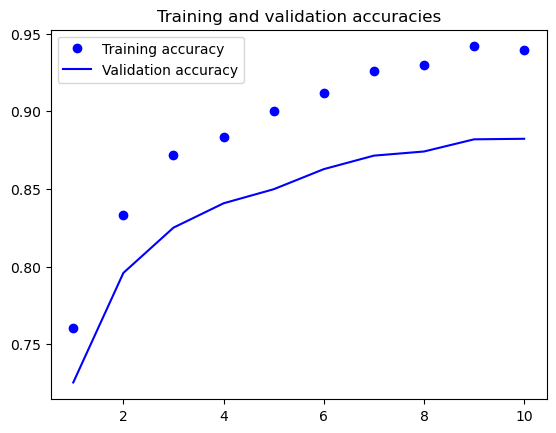

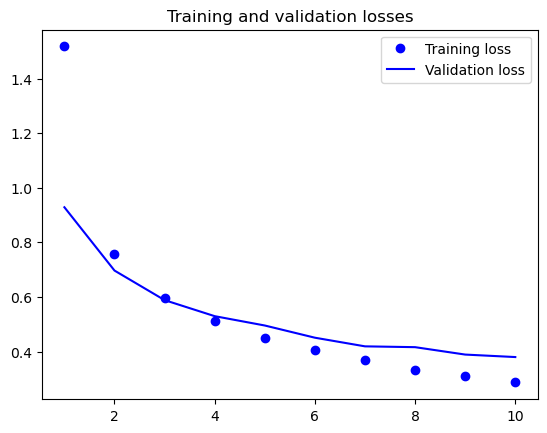

In [44]:
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracies')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()

plt.show()

## Evaluation

### Formatting the Test Set

In [45]:
# In X_dict, we replace the words with their index
X_test_cat, Y_test_cat = build_sequences(test_dict)
# We create the parallel sequences of indexes
X_test_idx = to_index(X_test_cat, word2idx)
Y_test_idx = to_index(Y_test_cat, pos2idx)

print('X[0] test idx', X_test_idx[0])
print('Y[0] test idx', Y_test_idx[0])

X_test_padded = pad_sequence(X_test_idx, batch_first=True)
Y_test_padded = pad_sequence(Y_test_idx, batch_first=True)
print('X[0] test idx passed', X_test_padded[0])
print('Y[0] test idx padded', Y_test_padded[0])
# One extra symbol for 0 (padding)


X[0] test idx tensor([386800, 186928, 164680, 250352, 192100,      1,  43061])
Y[0] test idx tensor([11, 14, 12, 16,  2, 12, 13])
X[0] test idx passed tensor([386800, 186928, 164680, 250352, 192100,      1,  43061,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0])
Y[0] test idx padded tensor([11, 14, 12, 16,  2, 12, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

### Evaluation

In [46]:
# Evaluates with the padding symbol
test_accuracy = torch.sum(torch.mul(torch.argmax(model(X_test_padded), dim=-1) == Y_test_padded, 
                                    Y_test_padded > 0))
test_accuracy = test_accuracy.item()/torch.sum(Y_test_padded > 0)
test_accuracy

tensor(0.8862)

We reach 93.50 with bidirectional LSTMs

### We evaluate on all the test corpus

X_test

In [47]:
X_test_cat[0]

['what', 'if', 'google', 'morphed', 'into', 'googleos', '?']

X_test_padded

In [48]:
X_test_padded[0]

tensor([386800, 186928, 164680, 250352, 192100,      1,  43061,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0])

In [49]:
Y_test_probs_padded = model(X_test_padded)

Y_test

In [50]:
Y_test_cat[0]

['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT']

Y_test_padded

In [51]:
Y_test_padded[0]

tensor([11, 14, 12, 16,  2, 12, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

Y_test_probs

In [52]:
Y_test_probs_padded[0]

tensor([[ -7.8366,  -2.6894,  -2.2336,  ...,  -0.7807,  -6.2187,  -7.4392],
        [ -8.2538,  -4.4659,  -1.5934,  ...,  -1.7140,  -7.5081,  -7.8828],
        [-10.2279,  -3.0107,  -6.3875,  ...,   1.1375,  -2.2593,  -2.1735],
        ...,
        [ -3.4071,  -2.5710,  -2.4862,  ...,  -2.7163,   1.8093,  -2.4400],
        [ -2.7180,  -2.3127,  -2.1273,  ...,  -2.4318,   1.3837,  -2.1834],
        [ -2.0548,  -1.9606,  -1.7359,  ...,  -2.0992,   0.9978,  -1.8691]],
       grad_fn=<SelectBackward0>)

Y_test_hat

In [53]:
Y_test_pred = torch.argmax(Y_test_probs_padded, dim=-1)
Y_test_pred

tensor([[11, 14, 12,  ..., 17, 17, 17],
        [11, 14, 12,  ..., 17, 17, 17],
        [13, 16, 12,  ..., 17, 17, 17],
        ...,
        [ 1,  8,  8,  ..., 17, 17, 17],
        [12, 16,  1,  ..., 17, 17, 17],
        [11, 16,  5,  ..., 17, 17, 17]])

In [48]:
list(Y_test_pred[0])

[tensor(11),
 tensor(14),
 tensor(12),
 tensor(16),
 tensor(2),
 tensor(8),
 tensor(13),
 tensor(15),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 tensor(17),
 

In [54]:
list(map(lambda x: idx2pos.get(x.item()), Y_test_pred[0]))

['PRON',
 'SCONJ',
 'PROPN',
 'VERB',
 'ADP',
 'NOUN',
 'PUNCT',
 'X',
 'PUNCT',
 'PUNCT',
 'PUNCT',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X',
 'X']

### Remove padding

In [55]:
Y_test_probs = []
for sent_nbr, y_test_probs_padded in enumerate(Y_test_probs_padded):
    Y_test_probs += [y_test_probs_padded[:len(X_test_cat[sent_nbr])]]
print(Y_test_probs[:1])

[tensor([[ -7.8366,  -2.6894,  -2.2336,   2.3920,  -3.0667,  -3.2484,   0.1910,
          -1.7149,  -1.2377,  -4.8933,  -3.1109,   4.7258,  -2.2764,  -4.1037,
           3.2632,  -8.3828,  -0.7807,  -6.2187,  -7.4392],
        [ -8.2538,  -4.4659,  -1.5934,   0.3764,   1.3505,  -1.9457,   0.5104,
          -4.0050,  -3.4868,  -7.3134,  -0.3401,   1.9606,  -2.3264,  -2.6471,
           4.2986,  -7.4718,  -1.7140,  -7.5081,  -7.8828],
        [-10.2279,  -3.0107,  -6.3875,  -0.1776,  -1.7252,  -8.0124,  -7.4768,
          -3.5898,   0.8041,  -4.3489,  -5.6336,  -3.5839,   3.4089,  -5.5116,
          -3.4603,  -6.7082,   1.1375,  -2.2593,  -2.1735],
        [ -9.1154,  -0.9611,  -2.1400,   2.0866,  -1.7908,  -5.7849,  -6.1675,
          -3.2285,   0.1057,  -4.8493,  -6.0887,  -3.7123,  -1.2044,  -6.3737,
          -2.8230,  -7.2679,   6.3191,  -4.0297,  -4.7635],
        [ -8.4285,  -0.6615,   6.4033,   2.8037,  -5.1900,  -1.7585,  -0.3405,
          -6.7756,  -2.1486,  -3.0411,  -3.6644,

### Convert POS indices to symbols

In [56]:
Y_test_cat_hat = []
for y_probs in Y_test_probs:
    y_idx = list(torch.argmax(y_probs, dim=-1))
    y_cat_hat = list(map(lambda x: idx2pos.get(x.item()), y_idx))
    Y_test_cat_hat += [y_cat_hat]

print(Y_test_cat_hat[:2])
print(Y_test_cat[:2])

[['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'NOUN', 'PUNCT'], ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PRON', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'CCONJ', 'ADV', 'NOUN', 'PUNCT', 'VERB', 'ADP', 'DET', 'ADJ', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']]
[['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PROPN', 'PUNCT'], ['PRON', 'SCONJ', 'PROPN', 'VERB', 'ADP', 'PRON', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'CCONJ', 'ADV', 'NOUN', 'PUNCT', 'NOUN', 'ADP', 'DET', 'ADV', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']]


### Evaluate

In [57]:
total, correct, total_ukn, correct_ukn = 0, 0, 0, 0
for id_s, x_test_cat in enumerate(X_test_cat):
    for id_w, word in enumerate(x_test_cat):
        total += 1
        if Y_test_cat_hat[id_s][id_w] == Y_test_cat[id_s][id_w]:
            correct += 1
        # The word is not in the dictionary
        if word not in word2idx:
            total_ukn += 1
            if Y_test_cat_hat[id_s][id_w] == Y_test_cat[id_s][id_w]:
                correct_ukn += 1

print('total %d, correct %d, accuracy %f' % 
      (total, correct, correct / total))
if total_ukn != 0:
    print('total unknown %d, correct %d, accuracy %f' % 
          (total_ukn, correct_ukn, correct_ukn / total_ukn))

total 25456, correct 22559, accuracy 0.886196
total unknown 560, correct 327, accuracy 0.583929


## Prediction of parts of speech

In [59]:
def predict_sentence(sentence, model, word2idx, idx2pos, verbose=False):
    # Predict one sentence
    sentence = sentence.split()
    word_idxs = to_index([sentence], word2idx)
    pos_idx_pred = model(word_idxs[0])
    pos_idxs = torch.argmax(pos_idx_pred, dim=-1)
    pos = list(map(lambda x: idx2pos.get(x.item()), pos_idxs))
    if verbose:
        print('Sentence', sentence)
        print('Sentence word indexes', word_idxs)
        #print('Padded sentence', word_idx_padded)
        print('POS predicted', pos_idx_pred[0])
        print('POS shape', pos_idx_pred.shape)
    return pos

In [60]:
sentences = ['That round table might collapse .',
                 'The man can learn well .',
                 'The man can swim .',
                 'The man can simwo .']
for sentence in sentences:
    y_test_cat_hat = predict_sentence(sentence.lower(), 
                                       model, word2idx, 
                                       idx2pos)
    print(sentence)
    print(y_test_cat_hat)

That round table might collapse .
['SCONJ', 'ADJ', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can learn well .
['DET', 'NOUN', 'AUX', 'VERB', 'ADV', 'PUNCT']
The man can swim .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can simwo .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
